In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./New Commerce Specialist Task - Draft - Task 1 - Database.csv") 
df.head(5)

,Order Created Time,Order ID,Restaurant ID,Title,Currency,Quantity,Unit Price (with VAT),Total (without VAT),Total (with VAT),Bolt Service Fee,Unit Price (Without VAT)
0,2021-12-22 12:51:05,ZZW,18269,ProductBottle,eur,1,2.49,11.33,13.58,1.13,2.08
1,2021-12-22 12:51:05,ZZW,18269,ProductBottle,eur,1,10.99,11.33,13.58,1.13,9.16
2,2021-12-22 12:51:05,ZZW,18269,Deposit,eur,1,0.10,11.33,13.58,1.13,0.10
3,2021-12-26 15:27:27,ZY4,18256,ProductBottle,eur,1,35.99,29.99,35.99,3.02,29.99
4,2021-12-28 20:05:00,ZY0,18256,ProductBottle,eur,1,8.19,6.83,8.19,0.68,6.82


### Going through the Data

In [3]:
df.dtypes

Order Created Time           object
Order ID                     object
Restaurant ID                 int64
Title                        object
Currency                     object
Quantity                      int64
Unit Price (with VAT)       float64
Total (without VAT)         float64
Total (with VAT)            float64
Bolt Service Fee            float64
Unit Price (Without VAT)    float64
dtype: object

In [4]:
df.isnull().sum()

Order Created Time          0
Order ID                    0
Restaurant ID               0
Title                       0
Currency                    0
Quantity                    0
Unit Price (with VAT)       0
Total (without VAT)         0
Total (with VAT)            0
Bolt Service Fee            0
Unit Price (Without VAT)    0
dtype: int64

In [5]:
df['Restaurant ID'].nunique() # Identifing how many unnique Restuarants are in the dataset

11

In [6]:
# Filter the dataframe to only include rows where "Title" is equal to "Deposit"
deposit_rows = df[df["Title"] == "Deposit"]

# Get the unique values of the "Unit Price (with VAT)" column in the filtered dataframe
unique_unit_prices = deposit_rows["Unit Price (with VAT)"].unique()

print(unique_unit_prices)

[0.1]


We can identify that theres 11 Restaurant in this dataset and that the Deposit is always 0.1, that tells me it's most likely the Bottle recycling tax. I noticed that the dataset is 2 weeks long so I decided to split it into 2 weeks for later easier analysis.

In [7]:
df['Quantity Total'] = df[(df['Title'] == 'ProductBottle')].groupby('Order ID')['Quantity'].transform('sum')
df.fillna(0, inplace=True)

In [8]:
# Convert the "Order Created Time" column to datetime
df["Order Created Time"] = pd.to_datetime(df["Order Created Time"])

# Create a new column called "Week"
df["Week"] = 0

# Define the date ranges for week 1 and week 2
week1_start = pd.to_datetime("2021-12-19")
week1_end = pd.to_datetime("2021-12-26")
week2_start = pd.to_datetime("2021-12-26")
week2_end = pd.to_datetime("2022-01-02")

# Fill in the "Week" column
df.loc[(df["Order Created Time"] >= week1_start) & (df["Order Created Time"] <= week1_end), "Week"] = 1
df.loc[(df["Order Created Time"] >= week2_start) & (df["Order Created Time"] <= week2_end), "Week"] = 2


In [9]:
df['Week'].unique()

array([1, 2])

In [10]:
df['Day of Week'] = df['Order Created Time'].dt.day_name()

In [11]:
# Define the bin edges for the 'DayTime' column
bin_edges = [0, 6, 12, 18, 24]

# Define the labels for the 'DayTime' column
bin_labels = ["Night", "Morning", "Afternoon", "Evening"]

# Extract the hour from the datetime column
df['Hour'] = df['Order Created Time'].dt.hour

# Create the 'DayTime' column based on the hour of the day
df['DayTime'] = pd.cut(df['Hour'], bins=bin_edges, labels=bin_labels, right=False)

df = df.drop(columns=['Hour'])



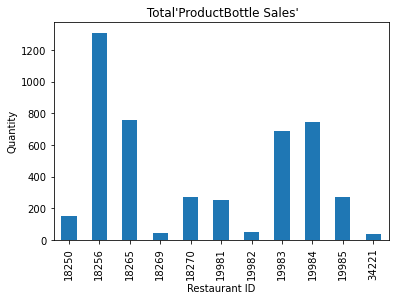

In [12]:
## Total units sold for every Restaurant
grouped_df = df[df['Title'] == 'ProductBottle'].groupby('Restaurant ID')['Quantity'].sum()

grouped_df.plot(kind='bar')
plt.xlabel("Restaurant ID")
plt.ylabel("Quantity")
plt.title(" Total'ProductBottle Sales'")
plt.show()


In [13]:
df = df.drop_duplicates(subset='Order ID')
df.head(5)

,Order Created Time,Order ID,Restaurant ID,Title,Currency,Quantity,Unit Price (with VAT),Total (without VAT),Total (with VAT),Bolt Service Fee,Unit Price (Without VAT),Quantity Total,Week,Day of Week,DayTime
0,2021-12-22 12:51:05,ZZW,18269,ProductBottle,eur,1,2.49,11.33,13.58,1.13,2.08,2.0,1,Wednesday,Afternoon
3,2021-12-26 15:27:27,ZY4,18256,ProductBottle,eur,1,35.99,29.99,35.99,3.02,29.99,1.0,2,Sunday,Afternoon
4,2021-12-28 20:05:00,ZY0,18256,ProductBottle,eur,1,8.19,6.83,8.19,0.68,6.82,1.0,2,Tuesday,Evening
5,2021-12-22 20:42:22,ZU0,19983,Deposit,eur,1,0.10,20.26,24.25,1.44,0.10,0.0,1,Wednesday,Evening
10,2021-12-26 18:01:48,ZTX,18265,ProductBottle,eur,1,6.99,5.83,6.99,0.59,5.83,1.0,2,Sunday,Evening


This barchart shows the Quanitity of products each Restaurant has sold for the past 2 weeks.

In [14]:
#Average basket value for each Restaurant
df.groupby('Restaurant ID').apply(lambda x: x['Total (with VAT)'].sum() / x['Quantity Total'].sum())

Restaurant ID
18250     7.564173
18256     9.288654
18265     6.825271
18269     6.734167
18270     9.468114
19981     9.184952
19982     8.327818
19983     6.589549
19984     7.350378
19985    10.248594
34221     9.603235
dtype: float64

In [15]:
#Average basket value devided by total order count
result = df.groupby('Restaurant ID').apply(lambda x: x['Total (with VAT)'].sum() / len(x['Order ID'].unique()))
result = result.round(2)
print(result)

Restaurant ID
18250    26.68
18256    38.82
18265    22.11
18269    24.86
18270    24.81
19981    25.47
19982    35.23
19983    26.89
19984    22.75
19985    22.88
34221    25.12
dtype: float64


Finding the average basket value for every Restaurant.

In [16]:
# 1.1 Total GMV
gmv = df["Total (with VAT)"].sum()
print("GMV:", gmv)


GMV: 29839.4


In [17]:
# Earnings per Quantity
result = df.groupby('Restaurant ID')['Total (with VAT)'].sum() / df.groupby('Restaurant ID')['Quantity Total'].sum()
print(result)

Restaurant ID
18250     7.564173
18256     9.288654
18265     6.825271
18269     6.734167
18270     9.468114
19981     9.184952
19982     8.327818
19983     6.589549
19984     7.350378
19985    10.248594
34221     9.603235
dtype: float64


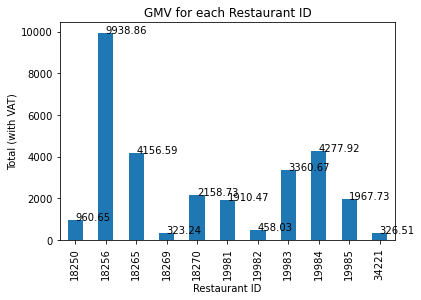

In [18]:
# 1.2 Total GMV at Restaurant level
# Filter the data by 'Week' 1 and 'Week' 2
df = df[(df['Week'] == 1) | (df['Week'] == 2)]

# Group the data by 'Restaurant ID' and sum the 'Total (with VAT)' column
grouped_data = df.groupby('Restaurant ID')['Total (with VAT)'].sum()

# Create a bar chart comparing the GMV 'Total (with VAT)' for each unique 'Restaurant ID'
ax = grouped_data.plot(kind='bar')
plt.xlabel('Restaurant ID')
plt.ylabel('Total (with VAT)')
plt.title('GMV for each Restaurant ID')

# Loop through each bar and annotate with the value
for i, v in enumerate(grouped_data):
    ax.text(i, v, str(round(v, 2)))

plt.show()

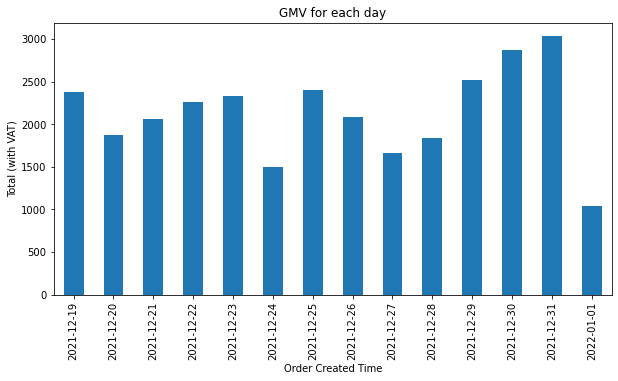

In [19]:
# 1.4 GMV at day of week level overall
# Convert the Order Created Time column to a datetime type
df['Order Created Time'] = pd.to_datetime(df['Order Created Time'])

# Extract the date from the Order Created Time column
df['Date'] = df['Order Created Time'].dt.date

# Group the data by date and sum the values in the Total (with VAT) column
grouped = df.groupby('Date')['Total (with VAT)'].sum()

# Plot the result as a bar chart
grouped.plot(kind='bar', figsize=(10,5))
plt.xlabel('Order Created Time')
plt.ylabel('Total (with VAT)')
plt.title('GMV for each day')

# Show the plot
plt.show()


We know that partners total gross merchandise volume is 29839.4 eur, and the best performing Restaurant is 18256. On 1. January there is a significant drop.

In [20]:
#2.1 Total Order counts
# Total Order counts
order_frequency = df["Order ID"].nunique()
print("Total Orders:", order_frequency)

Total Orders: 1080



Order Frequency:
Restaurant ID
18250     36
18256    256
18265    188
18269     13
18270     87
19981     75
19982     13
19983    125
19984    188
19985     86
34221     13
Name: Order ID, dtype: int64


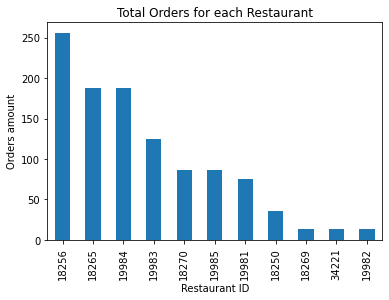

In [21]:
#2.2 Total Order each restaurants
# Calculate the order frequency
order_frequency = df.groupby('Restaurant ID')['Order ID'].nunique()
print("\nOrder Frequency:")
print(order_frequency)

# count number of orders for each restaurant ID
order_counts = df['Restaurant ID'].value_counts()

# plot column chart
order_counts.plot(kind='bar')

# add labels and title to chart
plt.xlabel('Restaurant ID')
plt.ylabel('Orders amount')
plt.title('Total Orders for each Restaurant')

# show chart
plt.show()

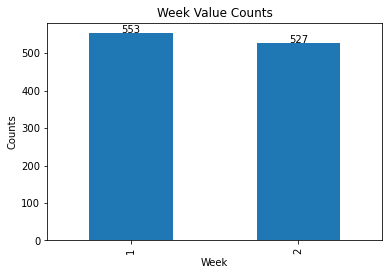

In [22]:
#2.3 Order at week level 
week_counts = df['Week'].value_counts()
week_counts.plot(kind='bar')
plt.xlabel('Week')
plt.ylabel('Counts')
plt.title('Week Value Counts')

for i, v in enumerate(week_counts):
    plt.text(x=i, y=v+0.5, s=v, ha='center')

plt.show()

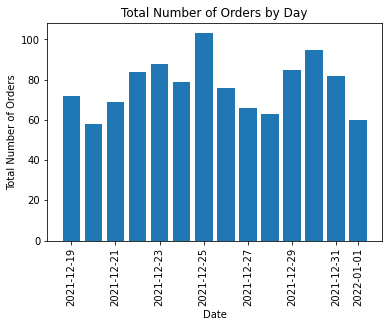

In [23]:
## 2.4 Order at day of week level
# Extract the date from the Order Created Time column
df['Date'] = df['Order Created Time'].dt.date

# Group by day and sum the total amount of orders for each day
df_grouped = df.groupby('Date').size().reset_index(name='Total Orders')

# Plot the total number of orders by day using a bar chart
plt.bar(df_grouped['Date'], df_grouped['Total Orders'])
plt.xlabel('Date')
plt.ylabel('Total Number of Orders')
plt.title('Total Number of Orders by Day')
plt.xticks(rotation=90)
plt.show()


All Resturants combined have made a total of 1080 orders, Restaurant 18256 with 256 (most) Orders and 34221 with only 13 orders. (my assumption that some Restaurant were closed on the holidays)

In [24]:
#4.1 Partner expenses total
service_fee = df["Bolt Service Fee"].sum()
print("Partner Expneses Total:", service_fee)

Partner Expneses Total: 2331.16


In [25]:
#4.2 Expenses each restaurants total
service_fee = df.groupby('Restaurant ID')['Bolt Service Fee'].sum()
print("\nExpenses for each Restaurant:")
print(service_fee)


Expenses for each Restaurant:
Restaurant ID
18250     76.37
18256    786.85
18265    313.77
18269     26.99
18270    168.79
19981    146.34
19982     35.41
19983    258.65
19984    341.50
19985    149.07
34221     27.42
Name: Bolt Service Fee, dtype: float64


In [26]:
# 4.3 Avarage Commision cost
avg = df['Bolt Service Fee'].mean()
print(avg)

2.158481481481479


In [27]:
# Bolt fee per Quantity
result = df.groupby("Restaurant ID")["Bolt Service Fee"].sum() / df.groupby("Restaurant ID")["Quantity Total"].sum()
print(result)

Restaurant ID
18250    0.601339
18256    0.735374
18265    0.515222
18269    0.562292
18270    0.740307
19981    0.703558
19982    0.643818
19983    0.507157
19984    0.586770
19985    0.776406
34221    0.806471
dtype: float64


In [28]:
# Average Bolt Commission per order
result = df.groupby("Restaurant ID")["Bolt Service Fee"].mean()
result = result.round(2)
print(result)

Restaurant ID
18250    2.12
18256    3.07
18265    1.67
18269    2.08
18270    1.94
19981    1.95
19982    2.72
19983    2.07
19984    1.82
19985    1.73
34221    2.11
Name: Bolt Service Fee, dtype: float64


In [29]:
df.head(5)

,Order Created Time,Order ID,Restaurant ID,Title,Currency,Quantity,Unit Price (with VAT),Total (without VAT),Total (with VAT),Bolt Service Fee,Unit Price (Without VAT),Quantity Total,Week,Day of Week,DayTime,Date
0,2021-12-22 12:51:05,ZZW,18269,ProductBottle,eur,1,2.49,11.33,13.58,1.13,2.08,2.0,1,Wednesday,Afternoon,2021-12-22
3,2021-12-26 15:27:27,ZY4,18256,ProductBottle,eur,1,35.99,29.99,35.99,3.02,29.99,1.0,2,Sunday,Afternoon,2021-12-26
4,2021-12-28 20:05:00,ZY0,18256,ProductBottle,eur,1,8.19,6.83,8.19,0.68,6.82,1.0,2,Tuesday,Evening,2021-12-28
5,2021-12-22 20:42:22,ZU0,19983,Deposit,eur,1,0.10,20.26,24.25,1.44,0.10,0.0,1,Wednesday,Evening,2021-12-22
10,2021-12-26 18:01:48,ZTX,18265,ProductBottle,eur,1,6.99,5.83,6.99,0.59,5.83,1.0,2,Sunday,Evening,2021-12-26


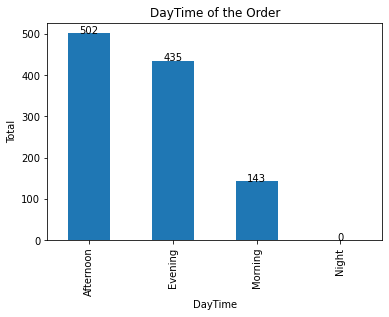

In [30]:
# count number of orders for each DayTime
order_counts = df['DayTime'].value_counts()

# plot column chart
order_counts.plot(kind='bar')

# add labels and title to chart
plt.xlabel('DayTime')
plt.ylabel('Total')
plt.title('DayTime of the Order')

for i, v in enumerate(order_counts):
    plt.text(i, v, str(v), ha='center')

plt.show()

In [31]:
# Creating a Table
grouped_df = df.groupby('Day of Week').agg({'Order ID': 'count', 'Total (with VAT)': 'sum', 
                                            'Bolt Service Fee': 'sum'})
grouped_df['Bolt commission per order'] = grouped_df['Bolt Service Fee'] / grouped_df['Order ID']

grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.rename(columns={'Order ID': 'Count of Order ID', 
                                        'Total (with VAT)': 'Sum of Total (with VAT)', 
                                        'Bolt Service Fee': 'Sum of Bolt Service Fee'})

grouped_df['Day of Week'] = pd.Categorical(grouped_df['Day of Week'], 
                                           categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                                                       'Thursday', 'Friday', 'Saturday'], 
                                           ordered=True)
grouped_df.sort_values('Day of Week', inplace=True)

# Format the values with 2 decimal precision
grouped_df['Sum of Total (with VAT)'] = grouped_df['Sum of Total (with VAT)'].map('€{:,.2f}'.format)
grouped_df['Sum of Bolt Service Fee'] = grouped_df['Sum of Bolt Service Fee'].map('€{:,.2f}'.format)
grouped_df['Bolt commission per order'] = grouped_df['Bolt commission per order'].map('€{:,.2f}'.format)

print(grouped_df)

  Day of Week  Count of Order ID Sum of Total (with VAT)  \
3      Sunday                148               €4,456.57   
1      Monday                124               €3,537.51   
5     Tuesday                132               €3,889.41   
6   Wednesday                169               €4,784.50   
4    Thursday                183               €5,203.57   
0      Friday                161               €4,530.01   
2    Saturday                163               €3,437.83   

  Sum of Bolt Service Fee Bolt commission per order  
3                 €354.43                     €2.39  
1                 €288.63                     €2.33  
5                 €313.21                     €2.37  
6                 €366.01                     €2.17  
4                 €380.05                     €2.08  
0                 €351.14                     €2.18  
2                 €277.69                     €1.70  
